In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.neighbors import *
print("All modules have been imported")


All modules have been imported


In [2]:
# Image Augmentation
no_angles = 10
url = '/kaggle/input/mias-mammography/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')
# train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))    

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0
            
    return (info)

In [3]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys() 
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
#Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
450 135 59


In [4]:
base_model= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(16,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

# nca=NeighborhoodComponentsAnalysis(random_state=42,n_components=0.99)

# train_features=pca.fit_transform(train_features)
# val_features=pca.transform(val_features)
# test_features=pca.transform(test_features)



94773248/94765736 [==============================] - 1s 0us/step


# Applying NCA on features extracted from ResNet50 and using Standard Classifiers

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
rf=RandomForestClassifier()
xgb=XGBClassifier(objective='mlogloss',eval_metric='mlogloss',use_label_encoder=False)
knn=KNeighborsClassifier(n_neighbors=3)
lgbm=LGBMClassifier()
abc=AdaBoostClassifier()
sv=SVC()

print('---------------------------NCA Report------------------------------')
nca=NeighborhoodComponentsAnalysis(random_state=42,n_components=3)

print(' ')
print('-----------Performance of NCA-KNN Classifier-------------------')
nca.fit(train_features,y_train)
knn.fit(nca.transform(train_features), y_train)
acc_knn_val = knn.score(nca.transform(val_features), y_val)
acc_knn_test = knn.score(nca.transform(test_features), y_test)
print('Validation accuracy :{}'.format(acc_knn_val))
print('Test accuracy :{}'.format(acc_knn_test))
print(' ')

print('-----------Performance of NCA-XGBBOST Classifier-------------------')
nca.fit(train_features,y_train)
xgb.fit(nca.transform(train_features), y_train)
acc_xgb_val = xgb.score(nca.transform(val_features), y_val)
acc_xgb_test = xgb.score(nca.transform(test_features), y_test)
print('Validation accuracy :{}'.format(acc_xgb_val))
print('Test accuracy :{}'.format(acc_xgb_test))
print(' ')

print('-----------Performance of NCA-Random Forest Classifier-------------------')
nca.fit(train_features,y_train)
rf.fit(nca.transform(train_features), y_train)
acc_rf_val = rf.score(nca.transform(val_features), y_val)
acc_rf_test = rf.score(nca.transform(test_features), y_test)
print('Validation accuracy :{}'.format(acc_rf_val))
print('Test accuracy :{}'.format(acc_rf_test))
print(' ')

print('-----------Performance of NCA-AdaBoost Classifier-------------------')
nca.fit(train_features,y_train)
abc.fit(nca.transform(train_features), y_train)
acc_abc_val = abc.score(nca.transform(val_features), y_val)
acc_abc_test = abc.score(nca.transform(test_features), y_test)
print('Validation accuracy :{}'.format(acc_abc_val))
print('Test accuracy :{}'.format(acc_abc_test))
print(' ')

print('-----------Performance of NCA-LightGBM Classifier-------------------')
nca.fit(train_features,y_train)
lgbm.fit(nca.transform(train_features), y_train)
acc_lgb_val = lgbm.score(nca.transform(val_features), y_val)
acc_lgb_test = lgbm.score(nca.transform(test_features), y_test)
print('Validation accuracy :{}'.format(acc_lgb_val))
print('Test accuracy :{}'.format(acc_lgb_test))
print(' ')

print('-----------Performance of NCA-SVC Classifier-------------------')
nca.fit(train_features,y_train)
sv.fit(nca.transform(train_features), y_train)
acc_svc_val = sv.score(nca.transform(val_features), y_val)
acc_svc_test = sv.score(nca.transform(test_features), y_test)

print('Validation accuracy :{}'.format(acc_svc_val))
print('Test accuracy :{}'.format(acc_svc_test))





---------------------------NCA Report------------------------------
 
-----------Performance of NCA-KNN Classifier-------------------
Validation accuracy :0.4222222222222222
Test accuracy :0.3728813559322034
 
-----------Performance of NCA-XGBBOST Classifier-------------------
Validation accuracy :0.362962962962963
Test accuracy :0.3898305084745763
 
-----------Performance of NCA-Random Forest Classifier-------------------
Validation accuracy :0.3851851851851852
Test accuracy :0.3559322033898305
 
-----------Performance of NCA-AdaBoost Classifier-------------------
Validation accuracy :0.362962962962963
Test accuracy :0.3898305084745763
 
-----------Performance of NCA-LightGBM Classifier-------------------
Validation accuracy :0.35555555555555557
Test accuracy :0.3728813559322034
 
-----------Performance of NCA-SVC Classifier-------------------
Validation accuracy :0.4
Test accuracy :0.3898305084745763


# Using PCA and reducing dimensionality to 2 Components

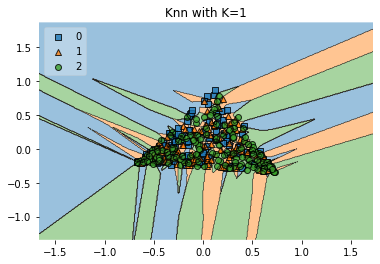

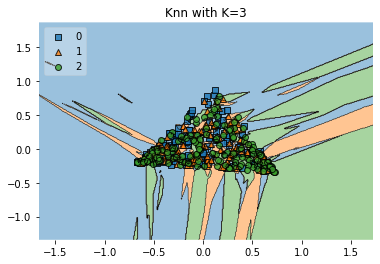

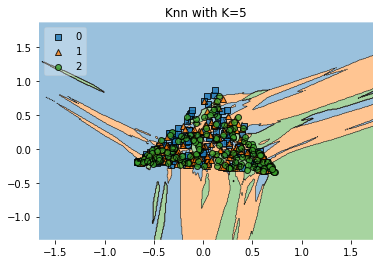

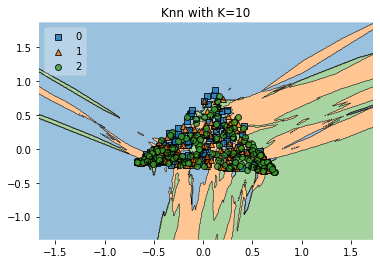

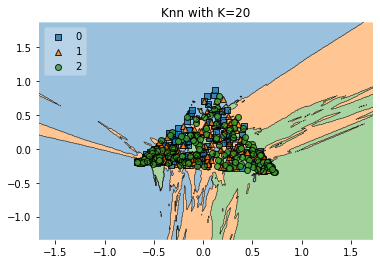

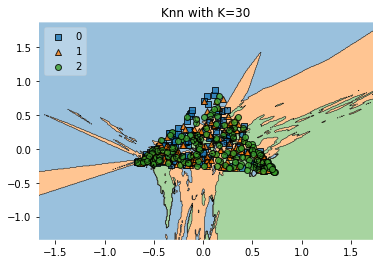

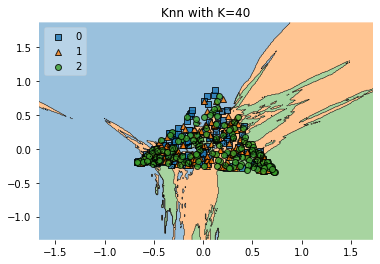

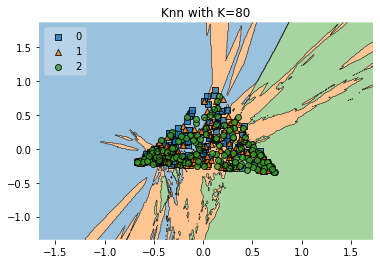

In [22]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import *
def knn_comparison(data1,data2, k):
 x = data1
 y = data2
 pca=PCA(n_components=2,random_state=42)
 x=pca.fit_transform(x)
 clf =KNeighborsClassifier(n_neighbors=k)
 clf.fit(x, y)
# Plotting decision region
 plot_decision_regions(x, y, clf=clf, legend=2)
# Adding axes annotations
 plt.title("Knn with K="+ str(k))
 plt.show()
for i in [1,3,5,10,20,30,40,80]:
    knn_comparison(train_features,y_train, i)